In [1]:
# Google Colab setup
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/My Drive/adl4cv")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# ONLY NECESSARY FOR LOCAL EXECUTION (WORKS WITHOUT THIS CELL IN GOOGLE COLAB)
# Setup that is necessary for jupyter notebook to find sibling-directories
# see: https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [0]:
# FROM i2dl for nice setup
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [0]:
# Imports for this notebook

from networks.baseline import BaselineModel
from training.solver import Solver
from training.single_image_dataloader import FaceForensicsImagesDataset, ToTensor
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler
import torch

In [0]:
data_location = ["/content/drive/My Drive/FaceForensics_Sequences/original_sequences/youtube/c40/sequences_299x299_skip_5_uniform",
                 "/content/drive/My Drive/FaceForensics_Sequences/manipulated_sequences/Deepfakes/c40/sequences_299x299_skip_5_uniform"]
dataset = FaceForensicsImagesDataset(data_location, transform=ToTensor())

In [5]:
# from: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

batch_size = 10
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

print("Train samples: {}".format(len(train_loader)))
print("Validation samples: {}".format(len(validation_loader)))

#for i, sample in enumerate(train_loader):
    
    #print("count of sequences in this batch: {}".format(sample["images"][0].shape[0]))
    
    #sequence = sample["images"][0][0, :, :, :, :]
    #labels_for_sequence = sample["labels"]
    #print(labels_for_sequence)
    
    #print(sequence.shape)
    #img = sequence[0].numpy()
    #img = np.moveaxis(img, 0, -1)  
    #plt.imshow(img)
    #plt.show()
    
    
    #print(sample["images"][0].shape)
    #print(sample["labels"][0].shape)

Train samples: 478
Validation samples: 120


In [6]:
# Load baseline model
model = BaselineModel(model_choice='xception', num_out_classes=2, dropout=0.0)
model.train_only_last_layer()

print(model)
print("----------")
print("Only the following layers require gradient backpropagation (param.requires_grad)")
for name, param in model.model.named_parameters():
    if param.requires_grad:
        print("param: {} requires_grad: {}".format(name, param.requires_grad))

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/checkpoints/xception-43020ad28.pth
100%|██████████| 87.4M/87.4M [04:17<00:00, 355kB/s]

BaselineModel(
  (model): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inp

In [8]:
#configure solver and start training
solver = Solver(optim=torch.optim.Adam,
                optim_args={ "lr": 1e-4,
                             "betas": (0.9, 0.999),
                             "eps": 1e-8,
                             "weight_decay": 0.0}, # is the l2 regularization parameter, see: https://pytorch.org/docs/stable/optim.html
                loss_func=torch.nn.CrossEntropyLoss())

# Baseline must be trained to get the last classification layer to work correctly, because Xception-net is pretrained on
# ImageNet with 1000 class outputs and we only need 2.

solver.train(model, train_loader, validation_loader, num_epochs=1, log_nth=1)

START TRAIN on device: cuda:0
[Iteration 1/478] TRAIN loss: 0.6347320675849915
[Iteration 2/478] TRAIN loss: 0.6353462934494019
[Iteration 3/478] TRAIN loss: 0.6174024343490601
[Iteration 4/478] TRAIN loss: 0.6313906908035278
[Iteration 5/478] TRAIN loss: 0.587356448173523
[Iteration 6/478] TRAIN loss: 0.5812312364578247
[Iteration 7/478] TRAIN loss: 0.6230813264846802
[Iteration 8/478] TRAIN loss: 0.5924926996231079
[Iteration 9/478] TRAIN loss: 0.5719059109687805
[Iteration 10/478] TRAIN loss: 0.7642951607704163
[Iteration 11/478] TRAIN loss: 0.7593225836753845
[Iteration 12/478] TRAIN loss: 0.7286803722381592
[Iteration 13/478] TRAIN loss: 0.7069947123527527
[Iteration 14/478] TRAIN loss: 0.5557142496109009
[Iteration 15/478] TRAIN loss: 0.5657580494880676
[Iteration 16/478] TRAIN loss: 0.4989081025123596
[Iteration 17/478] TRAIN loss: 0.5870479345321655
[Iteration 18/478] TRAIN loss: 0.5417600870132446
[Iteration 19/478] TRAIN loss: 0.7019908428192139
[Iteration 20/478] TRAIN loss:

TypeError: ignored

In [0]:
'''
print(dataset.__len__())
print(dataset.shape)
train_dataset = dataset[:20]
val_dataset = dataset[20:]

print(train_dataset.__len__())
print(val_dataset.__len__())


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

#for i, sample in enumerate(train_loader):
#    print(sample["images"][0].shape)
#    print(sample["labels"][0].shape)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

#solver.train(model, train_loader, val_loader, num_epochs=2, log_nth=1000)
'''

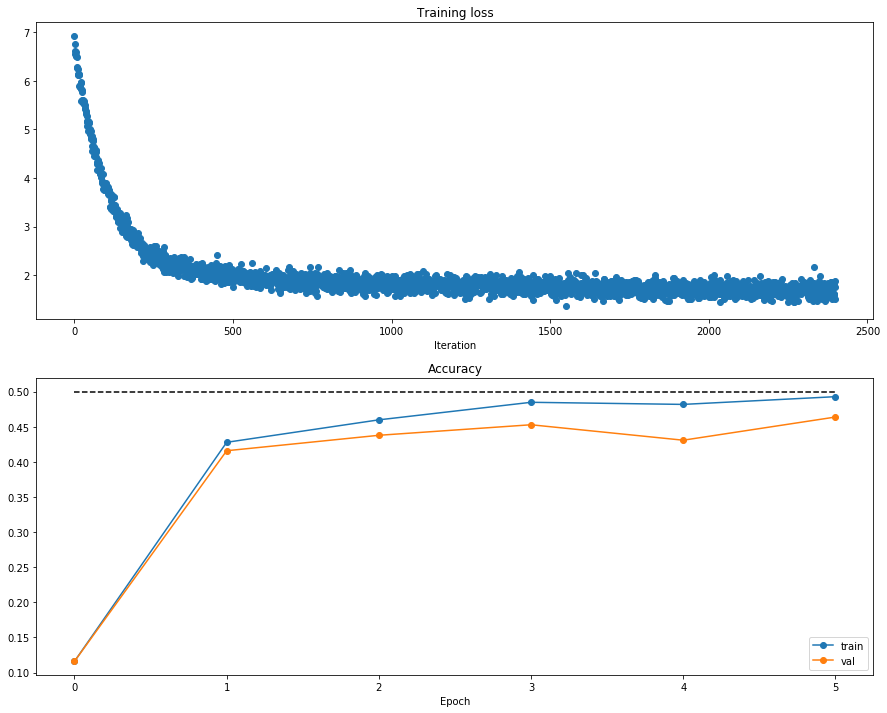

In [0]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

## Test your model
Run your best model on the validation and test sets. You should achieve score of above __50%__ accuracy on the validation set.

In [0]:
X_test = data['X_test']
X_val = data['X_val']
y_val = data['y_val']
y_test = data['y_test']

y_test_pred = np.argmax(best_model.loss(X_test), axis=1)
y_val_pred = np.argmax(best_model.loss(X_val), axis=1)
print('Validation set accuracy: ', (y_val_pred == y_val).mean())
print('Test set accuracy: ', (y_test_pred == y_test).mean())

Validation set accuracy:  0.553
Test set accuracy:  0.567
